# IFT 6758 - Assignment 3 

### Pt 2. Chess Ratings
**Comparing over/under represented groups**


Evaluation on this notebook:

- Figures for the rating and differences distributions
- Printed results from permutation tests
- Short answers (last section)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import chess_rating

E:\ift-6758\homeworks\hw3-en\release\chess_rating.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## 1. Load Data

### 1.1 Read XML data

In [4]:
xml_path = Path("data/standard_oct22frl_xml.xml")  # shouldn't need to change this

In [5]:
# TODO: complete this method in chess_rating.py
raw_df = chess_rating.parse_xml(xml_path)

In [6]:
# check to see a sample of 5 players
np.random.seed(0)
raw_df.sample(5)

,name,rating,sex,birthday,country,flag,title
181915,"Kouchaki Pirkouhi, Mohsen",1283,M,1990,IRI,None,None
159415,"Jonsson, Alfred",1680,M,1995,SWE,None,None
228502,"Mikhailova, Veronika",1117,F,2008,RUS,w,None
131173,"Guk, Evgeniy",2062,M,1937,RUS,i,None
93274,"D`Ambrosio, Francesco",1420,M,1937,ITA,i,None


In [7]:
# check to see the dtypes of the raw dataframe
raw_df.dtypes

name        object
rating      object
sex         object
birthday    object
country     object
flag        object
title       object
dtype: object

In [8]:
# also check to see how many null birthdays there are
raw_df.birthday.isnull().sum()

8477

### 1.2 Clean data

We want the birthdays (year of births) and rating (Elo) to be converted into integers so we can do numeric operations/logic with them (e.g. less than, greater than, etc). Complete the `clean_data()` method in `chess_rating.py`

In [9]:
# TODO: complete this method in chess_rating.py
df = chess_rating.clean_data(raw_df, 2002)

In [10]:
np.random.seed(0)
df.sample(5)

,name,rating,sex,birthday,country,flag,title
206801,"Lutzen, Mads",1542,M,2000,DEN,i,None
296314,"Rieckers, Dirk",1397,M,1964,GER,i,None
120235,"Gil, Celsio",1752,M,1999,STP,i,None
147860,"Hurwitz, Ed J G",2023,M,1964,ENG,i,None
124743,"Gonzalez Gomez, Pedro Daniel",1539,M,1997,ESP,None,None


In [11]:
df.dtypes

name        object
rating       int16
sex         object
birthday     int16
country     object
flag        object
title       object
dtype: object

In [12]:
df.birthday.isnull().sum()

0

## 2. Histograms of Elo ratings

We first want to compare the distribution of ratings for male and female players.
Since the data is quite fine-grained, we'll need to bin the ratings.
Complete the `bin_counts()` data, which should handle binning for arbitrary data and choice of bins.
In addition to returning the raw counts, also return the normalized counts in the dataframe (`"count_norm"`).

### 2.1 Binning data

Here are some test inputs to help you validate your implementation:

In [13]:
# sample inputs to help test your method
x = pd.DataFrame({'rating': [1, 2, 4, 6, 6, 7, 8, 11] })
bins = [0, 5, 10, 15]
bin_centers = [2.5, 7.5, 12.5]

# expected output
solution = pd.DataFrame({
    'rating': {0: 7.5, 1: 2.5, 2: 12.5},
     'count': {0: 4, 1: 3, 2: 1},
     'count_norm': {0: 0.5, 1: 0.375, 2: 0.125}
})

In [14]:
binned_output = chess_rating.bin_counts(x, bins, bin_centers)
binned_output

,rating,count,count_norm
0,7.5,4,0.500
1,2.5,3,0.375
2,12.5,1,0.125


In [15]:
solution.eq(binned_output)

,rating,count,count_norm
0,True,True,True
1,True,True,True
2,True,True,True


Now lets use this method to bin the ratings of male and female players, and compare.

In [16]:
# TODO: specify bin counts
bins = list(range(1000, 2901, 50))
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

In [17]:
# generate the histogram data 
# TODO: complete chess_rating.bin_counts()
M_hist = chess_rating.bin_counts(df.query("sex=='M'"), bins=bins, bin_centers=bin_centers)
F_hist = chess_rating.bin_counts(df.query("sex=='F'"), bins=bins, bin_centers=bin_centers)
M_hist['sex'] = 'M'
F_hist['sex'] = 'F'
hist = pd.concat([M_hist, F_hist],ignore_index=True)

E:\ift-6758\homeworks\hw3-en\release\chess_rating.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["binned_rating"] = pd.cut(df["rating"], bins=bins, labels=bin_centers)
E:\ift-6758\homeworks\hw3-en\release\chess_rating.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["binned_rating"] = pd.cut(df["rating"], bins=bins, labels=bin_centers)


Using the binned data, draw two lineplots of the binned data side by side; one containing the raw counts (`"count"`), and the other containing the normalized counts (`"count_norm"`), and M/F should be two different colours.

<AxesSubplot:xlabel='rating', ylabel='count_norm'>

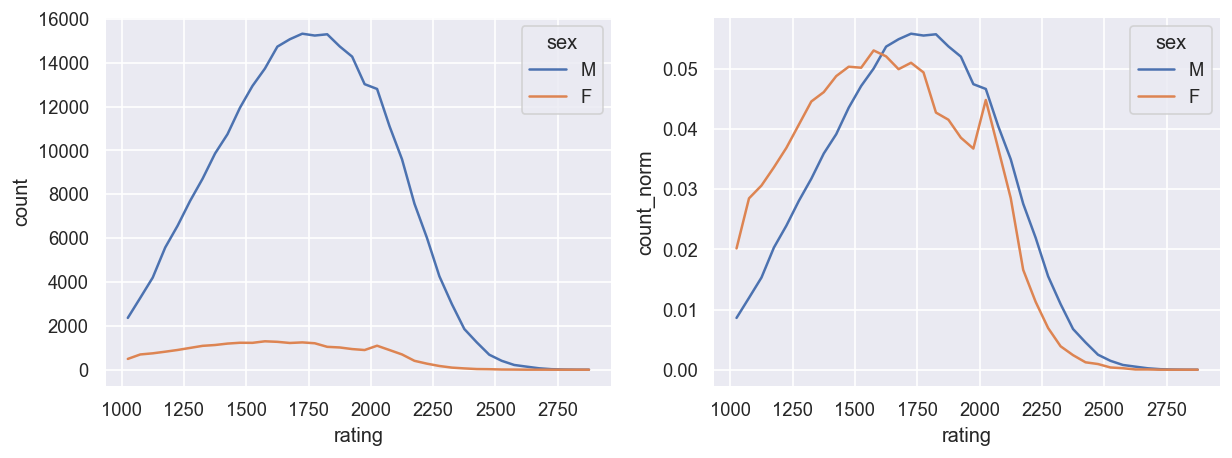

In [18]:
# Now draw the two histograms side-by-side. 
fig, ax = plt.subplots(1,2, figsize=(12, 4), dpi=120)
sns.lineplot(data=hist, x="rating", y="count", hue='sex', ax=ax[0])
sns.lineplot(data=hist, x="rating", y="count_norm", hue='sex', ax=ax[1])

## 3. Permutation Tests

We'll now conduct the permutation tests as outlined in the thought experiment of the introduction.
Take the full cleaned dataset (both male and females), and randomly sample two groups without replacement (i.e. shuffle the players). 
The size of the groups should reflect the real world difference we wish to study, i.e. the size of the male and female group.
Complete `chess_rating.PermutationTests.job()`, which implements the sampling part of this experiment, and returns the maximum value of the over and underrepresented groups respectively.

Then, complete the `chess_rating.sample_two_groups()` method, which runs this experiment `n_iter` times. 
Once completed, run this experiment in the notebook with at least `n_iter=1000`. 
Run the cell which prints the mean difference obtained from the permutation tests, as well as the real differences.

In [92]:
men_count = df["sex"].value_counts()[0]
women_count = df["sex"].value_counts()[1]
ratio = men_count/women_count
print(ratio)

11.24329863103533


In [90]:
# n_overrep = df["sex"].value_counts()[0]  # TODO
# n_underrep = df["sex"].value_counts()[1]  # TODO
n_overrep = 100000  #TODO
n_underrep = 10000  #TODO
over, under = chess_rating.sample_two_groups(df, n_overrep, n_underrep, n_iter=1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.37it/s]


In [93]:
diffs = over - under
max_M, max_F = df.query("sex=='M'").rating.max(), df.query("sex=='F'").rating.max()

In [94]:
print(f"Mean difference between top individuals in the over/under represented groups taken from the permutation experiments:")
print(f"\n\t{diffs.mean()} (std={diffs.std().round(2)})")
print()
print("Real values:\n")
print(f"\tMax M:\t\t{max_M}")
print(f"\tMax F:\t\t{max_F}")
print(f"\tReal difference: {max_M - max_F}")

Mean difference between top individuals in the over/under represented groups taken from the permutation experiments:

	83.673 (std=60.91)

Real values:

	Max M:		2856
	Max F:		2675
	Real difference: 181


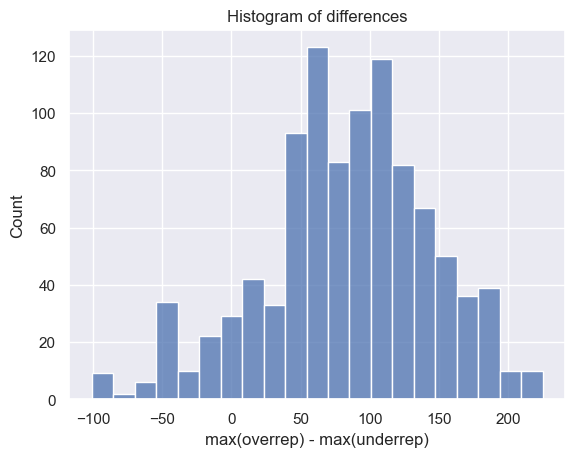

In [95]:
fig, ax = plt.subplots(1, 1, dpi=100)
sns.histplot(diffs, ax=ax).set(title="Histogram of differences", xlabel="max(overrep) - max(underrep)");

# Questions 

Give short answers to the following questions (1-3 lines each).

1. Interpret the results - can you come to any conclusion? Recall that claim discussed in the introduction to this question was "men are better than woman at chess because most of the top players are men". (*Note: presumably part of your answer here will involve your answer to the next question.*)

Conclusion: Comparing top players between men and women is not an accurate metric to quantify the skill level between sexes. This becomes apparent when we compare the ratings distribution of men & women taking into account their respective sample size. The average rating is quite close between the two sexes even with different population sizes suggesting that the difference in skill level although present is not as significant. 

2. Do you think the numbers obtained here tell the whole story? What might be some issues with the analysis conducted here? Is the data we are working with biased in any way (other than an overrepresentation bias)? Is ELO a good metric, and can it be used to answer the original question? Are there differences in the social, cultural, systemic treatment of men and women which may prevent the underrepresented group from achieving similar results? Anything else?

* While the permutation test sheds better light on the absolute difference between top players in the two groups and concludes that the difference is not as pronounced(83 vs 181) as it initally seemed to be, it still doesn't tell the whole story. 

* ELO score by design is a relative metric, it could be that women players are more likely to compete in women only tournaments(due to social/cultural factors) and thus they would have a lesser chance of obtaining the high tail end scores. This factor cannot be rectified by just increasing sample size for women and hence adds one more source of error to our data.

* Men are also more likely to play chess at professional level as the sponsorship revenue for men's tournaments is higher. This translates to higher no of male players crossing the ELO threshold and being counted in this dataset, therefore skewing the distribution to the tail end.

The point of these questions is to highlight that data is a limited representation of the real world.
It is critical for us as data scientists to take a step back when looking at a result and think about how it connects to the real world, rather than just naively assuming that the data and experimental setup is good which often results in flawed/incorrect conclusions. 
There could be multiple causal factors that determines the relationship that are independent to the original hypothesis: using data that doesn't really reflect the hypothesis you want to test, biased data (including overrepresented groups), real-world systemic differences between groups, etc.